In [1]:

import time
import pandas as pd
import glob
import numpy as np
import timeit
import pickle
import ast
from datetime import datetime
from collections import Counter
from scipy import stats
import re
# from func_simulate_game import *

pd.options.mode.chained_assignment = None  # default='warn'

from multiprocessing import Pool
from matplotlib import pyplot as plt
def toc(start_time):
    elapsed = timeit.default_timer() - start_time
    print(elapsed)
start_time = timeit.default_timer()

# import matplotlib.pyplot as plt

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 8, 'font.style': 'normal', 'font.family':'serif'})
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 8, 'font.style': 'normal', 'font.family':'serif'})
#matplotlib.rcParams.update({'font.size': 18})

path_dicts='/mnt/sdb1/sandeep/dicts_chess/'

# with open(file_to_read) as f:
#     exec(f.read())
    
# import ast
path_='/mnt/sdb1/sandeep/0. Careers in chess/'

In [74]:
p=Pool(processes=15)
names=path_dicts+"parquets/a_sorted_full_careers*"

# names=path_dicts+"parquets/dict_full_careers*" # all files
files=sorted(glob.glob(names))
df_careers = pd.concat(p.map(pd.read_parquet,files),ignore_index=True)
# df_careers = pd.read_parquet(names)

print('loaded careers=',toc(start_time))


p.close()

17426.185051947832
loaded careers= None


### Finding career start and ends within the dataframe

In [75]:
ids=np.array(df_careers['player_id'])
ind=np.where(~(ids[1:ids.shape[0]]==ids[0:ids.shape[0]-1]))
ind=ind[0]
career_lens=ind[1:len(ind)]-ind[0:len(ind)-1]
print(sum(np.array(career_lens)>100))
ind=[0]+list(ind)
len(ind)

208699


978868

In [2]:
# df_career_it

###  Top 3 frequent openings vs win rates (as white) without first 100 games

In [3]:
from collections import Counter
store_entropy_op=[]
store_ind=[]
store_rating=[]
t_ic = time.time();
fig = plt.figure(0,figsize=(10, 8));
plot_num=0;n_plots=4
career_in_focus=0


store_wins_=[];store_op_counts_=[]
# for it in range(len(ind)-1):
for it in range(career_in_focus,career_in_focus+1000000):

    if it % 5000 == 0:
        t_oc = time.time();
        print('career number=','-----',it/(len(ind)-1),', actual done = ', plot_num)
        with open("/mnt/sdb1/sandeep/0. Careers in chess/a_entropy_calc.txt", "a") as file_object:
            file_object.write('--'+str(it/(len(ind)-1))+'--i.e.-'+str(it)+'/'+str(len(ind)-1)+'----time (s)-'+str(round(t_oc-t_ic,2))+'\n')

#     print('career=',it/(len(ind)-1),end='\r')
    if ind[it+1]-ind[it]>300:

        df_career_it=df_careers.iloc[ind[it]+1:ind[it+1]+1,:]
        df_career_it=df_career_it[df_career_it['event_type']=='Rated Blitz game'];
        df_career_it["op_short"]=df_career_it.opening_.str.split(':').str[0]
        df_career_it_white=df_career_it[df_career_it['is_white']==1]
    
        df_career_it_white=df_career_it_white.iloc[100:df_career_it_white.shape[0],:] # ignoring first 100 games 
        df_op_counts=df_career_it_white.groupby(['op_short']).count();        df_op_wins=df_career_it_white[df_career_it_white['won_']==1].groupby(['op_short']).count();
        df_op_counts=df_op_counts.sort_values(['player_id'],ascending=False);        
        df_op_counts=df_op_counts.iloc[0:3,:] # TOP 3 MOST FREQUENT OPENING ONLY
        # df_op_counts=df_op_counts[df_op_counts['player_id']>50];
        op_counts=np.array(df_op_counts.iloc[:,0]);  
        
      
        if len(op_counts)==3:
            if op_counts[0]>100:
                wins_=[]
                for key_ in df_op_counts.index:
                    if key_ in df_op_wins.index:
                        ind_op=np.where(df_op_wins.index==key_)
                        wins_.append(df_op_wins.iloc[ind_op[0][0],0])
                    else:
                        wins_.append(0)
                wins_=np.array(wins_)

                #------------------------------------------------
                # PLOT
                #------------------------------------------------
                plot_num=plot_num+1;

        #         ax = fig.add_subplot(n_plots, n_plots, plot_num);
        #         if (plot_num-1)%(n_plots)==0:
        #             ax.set(ylabel=r'% win rate');
        #         if (plot_num)>(n_plots*(n_plots-1)):
        #             ax.set(xlabel=r"number of times opening is played ");

        #         ax.plot(op_counts,100*np.divide(wins_,op_counts),'.-');
                store_wins_.append(wins_)
                store_op_counts_.append(op_counts)
                temp_rating=list(df_career_it_white.iloc[:,9-is_white])
                temp_rating=[int(x) for x in temp_rating if (not(x== np.NaN) and not(x== '?'))]
                store_rating.append(np.mean(np.array(temp_rating)))

                # ax.set_yscale('log',base=10)
    #     if plot_num>n_plots*n_plots-1:
    if plot_num>15000:
        
        break


In [336]:
store_wins_=np.array(store_wins_)
store_op_counts_=np.array(store_op_counts_)
winrates=np.divide(store_wins_,store_op_counts_)

frac_diff2and1=(store_op_counts_[:,1] - store_op_counts_[:,2])/store_op_counts_[:,1]
ind_s=np.where((frac_diff2and1>.1)&(store_op_counts_[:,2]>100))
ind_s=ind_s[0]
WINRATES_=winrates[ind_s,1]-winrates[ind_s,2]



In [337]:
store_rating=np.array(store_rating)

ELO_bins_=[0,1600,1900,int(np.floor(max(store_rating[ind_s])))]
ELO_bins_=[0,1400,1600,1800,2000,int(np.floor(max(store_rating[ind_s])))]
store_ind_for_ELO=[]
for it_bin in range(len(ELO_bins_)-1):
    high_ind=np.where((store_rating[ind_s]>ELO_bins_[it_bin])&(store_rating[ind_s]<ELO_bins_[it_bin+1]));
    high_ind=high_ind[0]
    store_ind_for_ELO.append(high_ind)

activity_=[]
for it_bin in range(len(ELO_bins_)-1):
    activity_.append(WINRATES_[store_ind_for_ELO[it_bin]])
    

4 ,  2 game lengths-  150  to  300
0<ELO<1400 vs 1400<ELO<1600 
 KstestResult(statistic=0.08669417626907505, pvalue=0.08110509251635523)
1400<ELO<1600 vs 1600<ELO<1800 
 KstestResult(statistic=0.14563177260361554, pvalue=6.439293542825908e-15)
1600<ELO<1800 vs 1800<ELO<2000 
 KstestResult(statistic=0.03583241455347299, pvalue=0.41622337768152207)
1800<ELO<2000 vs 2000<ELO<2497 
 KstestResult(statistic=0.039242400378012285, pvalue=0.7491718449386955)
0<ELO<1400 vs 1600<ELO<1800 
 KstestResult(statistic=0.2174048895455499, pvalue=1.6965966409543398e-09)


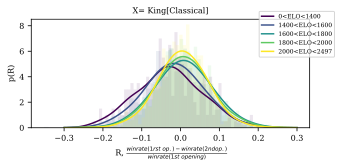

In [339]:
from scipy import stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version

# `normed` is being deprecated in favor of `density` in histograms
if parse_version(matplotlib.__version__) >= parse_version('2.1'):
    density_param = {'density': True}
else:
    density_param = {'normed': True}

    
#___________________________________________________________

fig = plt.figure(0,figsize=(5, 2));
ax = fig.add_subplot(1, 1, 1);


filtered_game_len=np.array(filtered_game_len)

bins_=51
TOTAL_GAMES_CONSIDERED_FOR_PLOT=100000

#             colors = ['navy', 'darkorange','red', 'cornflowerblue','tab:orange']
rangec = np.linspace(0,1,len(ELO_bins_)-1)
colors = [plt.cm.viridis(i) for i in rangec]

labels_=[str(ELO_bins_[x])+'<ELO<'+str(ELO_bins_[x+1]) for x in range(len(ELO_bins_)-1)]

nn=101

store_for_test=[]
print(ix,', ',iy, 'game lengths- ',MOVES_bins_[it_MOVES_bin],' to ',MOVES_bins_[it_MOVES_bin+1])

for it_bin in range(len(ELO_bins_)-1):
    ind_=np.where((filtered_game_len[it_bin]>=MOVES_bins_[it_MOVES_bin]) & (filtered_game_len[it_bin]<MOVES_bins_[it_MOVES_bin+1]) & 
                 (f_game_type_simplified[it_bin]==GAME_TYPE));

    X=activity_[it_bin]
    TILL_= min(TOTAL_GAMES_CONSIDERED_FOR_PLOT,len(X))
    # I take the number of points = TOTAL_GAMES if size X > size TOTAL_GAMES
    X=X[0:TILL_]
    store_for_test.append(X)
    X=X.reshape(-1, 1)
    p_=ax.hist(X,bins_,alpha=.1,density=True,color=colors[it_bin]);
    kde = KernelDensity(kernel='gaussian', bandwidth=0.03).fit(X)
    s = np.linspace(-.3,.3,nn) # This is the xrange
    log_dens = kde.score_samples(s.reshape(-1,1))
    ax.plot(s,np.exp(log_dens),color=colors[it_bin],label=labels_[it_bin])



# title_='X= '+pieces_[PIECE_ID]+', game lasted '+str(MOVES_bins_[it_MOVES_bin])+' to '+ str(MOVES_bins_[it_MOVES_bin+1])+' moves'+ '['+GAME_TYPE+']'
# title_='X= '+pieces_[PIECE_ID] + '['+GAME_TYPE+']'

ax.set_title(title_,fontsize=8);

ax.set(xlabel=r" R, $\frac{winrate(1rst \ op.) -winrate(2nd op.)}{win rate(1st \ opening)}$", ylabel=r'p(R)');

for it_bin in range(len(ELO_bins_)-2):
    print(labels_[it_bin]+' vs '+ labels_[it_bin+1],'\n',
          stats.ks_2samp(store_for_test[it_bin],store_for_test[it_bin+1]))
it_bin=0
print(labels_[it_bin]+' vs '+ labels_[it_bin+2],'\n',
          stats.ks_2samp(store_for_test[it_bin],store_for_test[it_bin+2]))


ax.legend(loc='upper right',fontsize=6,bbox_to_anchor=(1.1, 1.1));



#___________________________________________________________

### Opening entropy vs ELO

In [276]:
store_op_counts_.shape

(1001, 3)

In [275]:
# store_op_counts_=np.array(store_op_counts_)
# np.stack(store_op_counts_, axis=0)


### Response to weaker vs stronger players

In [ ]:

GAP_=50 # Opponnents with ELO gap 10 anbove or below are considered
store_entropyH=[]
store_entropyL=[]
store_rating=[]
store_ind=[]
t_ic = time.time();

career_in_focus=500000
# for it in range(len(ind)-1):
for it in range(career_in_focus):

    if it % 200 == 0:
        t_oc = time.time();
        print('career number=','-----',it,'---out of---',(career_in_focus),round(t_oc-t_ic,2),end='\r')
#         with open("/mnt/sdb1/sandeep/0. Careers in chess/a_entropy_calc.txt", "a") as file_object:
#             file_object.write('--'+str(it/(len(ind)-1))+'--i.e.-'+str(it)+'/'+str(len(ind)-1)+'----time (s)-'+str(round(t_oc-t_ic,2))+'\n')

#     print('career=',it/(len(ind)-1),end='\r')
    df_career_it=df_careers.iloc[ind[it]+1:ind[it+1]+1,:]
    df_career_it=df_career_it[df_career_it['event_type']=='Rated Blitz game'];
    df_career_it["op_short"]=df_career_it.opening_.str.split(':').str[0]
    df_career_it=df_career_it[df_career_it['termination_']=='Normal']
    df_career_it=df_career_it[~df_career_it.whiteelo.isin(['?',np.NaN])]
    df_career_it=df_career_it[~df_career_it.blackelo.isin(['?',np.NaN])]
    df_career_it['whiteelo']=pd.to_numeric(df_career_it['whiteelo'])
    df_career_it['blackelo']=pd.to_numeric(df_career_it['blackelo'])
    df_career_it['ELO_gap']=df_career_it['whiteelo']-df_career_it['blackelo']
    
    df_career_it["ELO_gap"]=np.where(df_career_it['is_white']==1,df_career_it["ELO_gap"],-df_career_it["ELO_gap"])

    df_against_higher=df_career_it[df_career_it["ELO_gap"]>=GAP_]
    df_against_lower=df_career_it[df_career_it["ELO_gap"]<=-GAP_]
    
    df_whiteH=df_against_higher[df_against_higher['is_white']==1]
    df_whiteL=df_against_lower[df_against_lower['is_white']==1]
#     df_career_it_black=df_career_it[df_career_it['is_white']==0]

    temp_rating=[]
    is_white=1 # CHAHNGE FOR BLACK
    if (df_whiteH.shape[0]>200) and (df_whiteL.shape[0]>200):

        temp_rating=list(df_whiteH.iloc[:,9-is_white])
        temp_rating=[int(x) for x in temp_rating if (not(x== np.NaN) and not(x== '?'))]

        #         df_op_counts=df_whiteH.groupby(['opening_']).count();
        df_op_counts=df_whiteH.groupby(['op_short']).count();
        
        op_counts=np.array(df_op_counts.iloc[:,0]);   
        prob_=op_counts/np.sum(op_counts)
        entropy_=-np.sum(np.multiply(prob_,np.log2(prob_)))
        store_ind.append(ind[it])
        store_rating.append(np.mean(np.array(temp_rating)))

        store_entropyH.append(entropy_)
        
        # STORING ENTROPY FOR LOWER
#         df_op_counts=df_whiteL.groupby(['opening_']).count();
        df_op_counts=df_whiteL.groupby(['op_short']).count();
        op_counts=np.array(df_op_counts.iloc[:,0]);   
        prob_=op_counts/np.sum(op_counts)
        entropy_=-np.sum(np.multiply(prob_,np.log2(prob_)))

        store_entropyL.append(entropy_)
#         store_higher
        
#------------------------------------------------
# PLOT
#------------------------------------------------
t_oc = time.time();
print(t_oc-t_ic,' seconds')

[CONTROL FOR GAME LENGTHS]

## Currently I am not saving the opening entropy of each agent to file
## *I should save it as a dictionary with username as key and  op entropy as value*
- do it two times for main opening vs opening lines
- also save the total number of games by player as white and as black (for filtering later)
- convert to pandas dataframe and save

4109
0<ELO<1600 vs 1600<ELO<1900 
 KstestResult(statistic=0.04817126819543597, pvalue=0.040027150189655525)
1600<ELO<1900 vs 1900<ELO<2473 
 KstestResult(statistic=0.0925583414610938, pvalue=0.0003537488790139598)
0<ELO<1600 vs 1900<ELO<2473 
 KstestResult(statistic=0.1126114769439827, pvalue=1.927506141863322e-05)


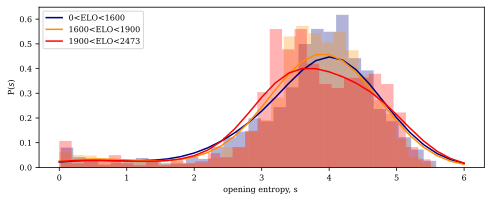

In [99]:
from scipy import stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version

# `normed` is being deprecated in favor of `density` in histograms
if parse_version(matplotlib.__version__) >= parse_version('2.1'):
    density_param = {'density': True}
else:
    density_param = {'normed': True}


#------------------------------------------------------
print(len(store_entropyH))
bins_=30
store_rating=np.array(store_rating);
store_entropyH=np.array(store_entropyH);
store_entropyL=np.array(store_entropyL);
colors = ['navy', 'darkorange','red', 'cornflowerblue']

ELO_bins_=[0,1600,1900,int(np.floor(max(store_rating)))]

# labels_ = ['ELO < 1500', '1500 < ELO < 1800 ', 'ELO > 1800']
labels_=[str(ELO_bins_[x])+'<ELO<'+str(ELO_bins_[x+1]) for x in range(len(ELO_bins_)-1)]
nn=31
fig = plt.figure(0,figsize=(8, 6.5));
ax = fig.add_subplot(2, 1, 1);

store_for_test=[]
for it_bin in range(len(ELO_bins_)-1):
    high_ind=np.where((store_rating>ELO_bins_[it_bin])&(store_rating<ELO_bins_[it_bin+1]));high_ind=high_ind[0]
    X=store_entropyL[high_ind]
    store_for_test.append(X)
    X=X.reshape(-1, 1)
    p_=ax.hist(X,bins_,alpha=.3,density=True,color=colors[it_bin]);
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)
    s = np.linspace(0,6,nn)
    log_dens = kde.score_samples(s.reshape(-1,1))
    ax.plot(s,np.exp(log_dens),color=colors[it_bin],label=labels_[it_bin])


# ax.hist(store_entropyL[high_ind],bins_,alpha=.3,density=True);
# ax.legend(store_lines,leg_,loc=(1.04,0));
ax.set(xlabel=r"opening entropy (against stronger vs weaker opponent), s ", ylabel=r'P($s$)');

ax.set(xlabel=r"opening entropy, s ", ylabel=r'P($s$)');

for it_bin in range(len(ELO_bins_)-2):
    print(labels_[it_bin]+' vs '+ labels_[it_bin+1],'\n',
          stats.ks_2samp(store_for_test[it_bin],store_for_test[it_bin+1]))
it_bin=0
print(labels_[it_bin]+' vs '+ labels_[it_bin+2],'\n',
          stats.ks_2samp(store_for_test[it_bin],store_for_test[it_bin+2]))

# print('12',stats.ks_2samp(store_for_test[1],store_for_test[2]))
# print('02',stats.ks_2samp(store_for_test[0],store_for_test[2]))

ax.legend(loc='upper left');


# ax = fig.add_subplot(2, 1, 2);
# ax.hist(store_rating,bins_,alpha=.3);

# ax.set_yscale('log',base=10)
# ax.set_xticks(np.linspace(12,48,4));

In [180]:
np.exp(log_dens)

array([10.21925318, 10.40429859, 10.20498532,  9.64582167,  8.78910613,
        7.72371322,  6.5501882 ,  5.36558794,  4.25115403,  3.26478093,
        2.43879694,  1.78228538,  1.28636904,  0.9306692 ,  0.68942799,
        0.53633282,  0.44767154,  0.40391239,  0.39007226,  0.39531881,
        0.41220453,  0.43581982,  0.46303309,  0.49188889,  0.52117245,
        0.55011627,  0.57821345,  0.60510453,  0.63051074,  0.65419514,
        0.67593973,  0.69553219,  0.71275957,  0.7274079 ,  0.73926788,
        0.7481457 ,  0.75387773,  0.75634653,  0.75549552,  0.75133979,
        0.7439714 ,  0.73355873,  0.72034037,  0.70461444,  0.6867249 ,
        0.66704556,  0.64596291,  0.62385847,  0.60109161,  0.57798428,
        0.55480907,  0.53178228,  0.50906275,  0.48675651,  0.46492604,
        0.44360227,  0.42279688,  0.40251283,  0.38275207,  0.36351982,
        0.3448261 ,  0.32668506,  0.30911326,  0.29212741,  0.27574209,
        0.25996795,  0.24481055,  0.23027015,  0.21634229,  0.20

In [101]:
len(store_entropyL)

4109

# Piece movement - Better players move their pieces differently?
- *ensure that your code works on games which have evaluation*
- deal with games with no known players, they appear conjoined with other games

## New list with games with numbers removed

In [2]:
# import re
# games_=list(df_careers.iloc[:,11])
# t_ic = time.time();

# new_games=[]
# career_in_focus=len(games_)
# for it_game in range(career_in_focus):
#     game_=games_[it_game]
#     game_=re.split(' ' ,game_)
    
#     a=1;game__=[]
#     for x in game_:
        
#         if x.startswith(str(a)):
#             a=a+1
#         else:
#             game__.append(x)
#     game__
#     y=''
#     for x in game__:
#         y=y+x+','
#     new_games.append(y)
#     if it_game % 100000 == 0:
#         t_oc = time.time();
#         print('career number=','-----',it_game/(career_in_focus),it_game,'---out of---',(career_in_focus),round(t_oc-t_ic,2),end='\r')
#         with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING02.txt", "a") as file_object:
#             file_object.write('--'+str(it_game/(career_in_focus))+'--'+str(it_game/(career_in_focus))+'--i.e.-'+str(it_game)+'/'+str(career_in_focus)+'----time (s)-'+str(round(t_oc-t_ic,2))+'\n')
# with open(path_dicts+'actual_games_all.pkl', 'wb') as f:
#     pickle.dump(new_games, f)

          



In [ ]:
#---------------------------------
# Loading saved file
#---------------------------------

with open(path_dicts+'actual_games_all.pkl', 'rb') as f:
    new_games = pickle.load(f)

df_careers.shape[0]# Analysis of moves in games (total points in begining = 39x2)
- control for game length
- if sum(a) or sum(b) ==0 ; dont consider the game because then number of total moves<2

In [ ]:
# t_ic = time.time();
# career_in_focus=len(new_games)
# # career_in_focus=int(.35*100000)


# store_game_lens=np.zeros([career_in_focus])
# store_a=np.zeros([career_in_focus,6])
# store_b=np.zeros([career_in_focus,6])


# for it_game in range(career_in_focus):

#     game_=new_games[it_game]
#     game_=re.split(',',game_)
#     L=len(game_)
#     store_game_lens[it_game]=(L-2)

#     if L<600:
#         gameW=game_[0:L-2:2]
#         La=len(gameW)
#         y='';
#         for x in gameW:
#             y=y+x+','
#         gameW=y
#         gameB=game_[1:L-2:2]
#         Lb=len(gameB)
#         y='';
#         for x in gameB:
#             y=y+x+','
#         gameB=y
#         pieces_=['N','B','R','Q','K']
#         a=[];b=[];
#         if not(La==0) and not(Lb==0):
#             for piece_ in pieces_:
#                     a.append(gameW.count(piece_)/La)
#                     b.append(gameB.count(piece_)/Lb)
#             a.append(1-sum(a));  b.append(1-sum(b))

#         else:
#             a=[0,0,0,0,0,0];b=[0,0,0,0,0,0];
#     else:
#         a=[0,0,0,0,0,0];b=[0,0,0,0,0,0];

#     store_a[it_game]=a;store_b[it_game]=b

#     if it_game % 50000== 0:
#         t_oc = time.time();
#         print('career number=','-----',it_game/(career_in_focus),it_game,'---out of---',(career_in_focus),round(t_oc-t_ic,2),end='\r')
#         with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING.txt", "a") as file_object:
#             file_object.write('--'+str(it_game/(career_in_focus))+'--i.e.-'+str(it_game)+'/'+str(career_in_focus)+'----time (s)-'+str(round(t_oc-t_ic,2))+'\n')



In [ ]:
# store_game_lens=np.array(store_game_lens)

# with open(path_dicts+'store_game_lengths.pkl', 'wb') as f:
#     pickle.dump(store_game_lens, f)
# with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING1.txt", "a") as file_object:
#     file_object.write('-------game_lengths-------\n')

# store_a=np.array(store_a)


# with open(path_dicts+'store_white_piece_activity.pkl', 'wb') as f:
#     pickle.dump(store_a, f)
# with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING1.txt", "a") as file_object:
#     file_object.write('-------white activity-------\n')
# store_b=np.array(store_b)
    
# with open(path_dicts+'store_black_piece_activity.pkl', 'wb') as f:
#     pickle.dump(store_b, f)
# with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING1.txt", "a") as file_object:
#     file_object.write('-------black activity-------\n')


In [2]:
          
#---------------------------------
# Loading saved file
#---------------------------------
with open(path_dicts+'store_white_piece_activity.pkl', 'rb') as f:
    store_a = pickle.load(f)
    
with open(path_dicts+'store_black_piece_activity.pkl', 'rb') as f:
    store_b = pickle.load(f)

with open(path_dicts+'store_game_lengths.pkl', 'rb') as f:
    store_game_lens = pickle.load(f)


## store acitivty of different pieces in 6 differnt numpy array and write to file
-----------------------------------------
## saves RAM

In [16]:
# pieces_=['N','B','R','Q','K','P']
# for it in range(store_a.shape[1]):
#     with open(path_dicts+'store_activity_of_white_'+pieces_[it]+'.pkl', 'wb') as f:
#         pickle.dump(store_a[:,it], f)
#     with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING2.txt", "a") as file_object:
#         file_object.write('-------activity piece by piece-------\n')
 
# for it in range(store_b.shape[1]):
#     with open(path_dicts+'store_activity_of_black_'+pieces_[it]+'.pkl', 'wb') as f:
#         pickle.dump(store_b[:,it], f)
#     with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING2.txt", "a") as file_object:
#         file_object.write('-------activity piece by piece-------\n')
 




## list of ELOs of the players in the game

In [6]:
# list_ELO=np.where(df_careers['is_white']==1,df_careers['whiteelo'],df_careers['blackelo'])
# list_ELO2=[]
# for x in list_ELO:
#     if (not(x== np.NaN) and not(x== '?')):
#         list_ELO2.append(int(x))
#     else:
#         list_ELO2.append(-1)
# list_ELO2=np.array(list_ELO2)
# with open(path_dicts+'store_all_ELOs.pkl', 'wb') as f:
#     pickle.dump(list_ELO2, f)
# with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING1.txt", "a") as file_object:
#     file_object.write('-------stored ELO list-------\n')
          


In [ ]:
#---------------------------------
# Loading saved file
#---------------------------------
    
with open(path_dicts+'store_all_ELOs.pkl', 'rb') as f:
    list_ELO2 = pickle.load(f)
    

In [113]:
# won_=np.array(df_careers['won_'])
# game_type=np.array(df_careers['event_type'])

# game_type_simplified=game_type.copy()
# it=0
# for game_ in game_type:
    
#     if 'Blitz' in game_:
#         game_type_simplified[it]='Blitz'
#     elif 'Bullet' in game_:
#         game_type_simplified[it]='Bullet'
#     elif 'Classical' in game_:
#         game_type_simplified[it]='Classical'
#     elif 'Standard' in game_:
#         game_type_simplified[it]='Standard'
#     elif 'Correspondence' in game_:
#         game_type_simplified[it]='Correspondence'
#     else:
#         game_type_simplified[it]=-1
#     it=it+1
    
        

In [ ]:

# with open(path_dicts+'game_type_simplified.pkl', 'wb') as f:
#     pickle.dump(game_type_simplified, f)
# with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING1.txt", "a") as file_object:
#     file_object.write('-------game_type_simplified-------\n')

#---------------------------------
# Loading saved file
#---------------------------------
with open(path_dicts+'game_type_simplified.pkl', 'rb') as f:
    game_type_simplified = pickle.load(f)
    

# #-------------------------------------------------------------------------------------------

# with open(path_dicts+'game_won_.pkl', 'wb') as f:
#     pickle.dump(won_, f)
# with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING1.txt", "a") as file_object:
#     file_object.write('-------won_-------\n')

#---------------------------------
# Loading saved file
#---------------------------------
with open(path_dicts+'game_won_.pkl', 'rb') as f:
    won_ = pickle.load(f)
    

    

### Filtering the games by ELO 


In [158]:
ELO_bins_=[0,1600,1900,int(np.floor(max(list_ELO2)))]
ELO_bins_=[0,1400,1600,1800,2000,int(np.floor(max(list_ELO2)))]
store_ind_for_ELO=[]

for it_bin in range(len(ELO_bins_)-1):
    high_ind=np.where((list_ELO2>ELO_bins_[it_bin])&(list_ELO2<ELO_bins_[it_bin+1]));
    high_ind=high_ind[0]
    store_ind_for_ELO.append(high_ind)


## Prerequisite: filtering games by length (number of moves) and game types (blitz, bullet , classical) etc 

In [160]:
store_game_lens=np.array(store_game_lens)
   
filtered_game_len=[]
for it_bin in range(len(ELO_bins_)-1):
    filtered_game_len.append(store_game_lens[store_ind_for_ELO[it_bin]])
    
activity_=[]
for it_bin in range(len(ELO_bins_)-1):
    activity_.append(store_a[store_ind_for_ELO[it_bin]])
    
        
f_game_type_simplified=[]
for it_bin in range(len(ELO_bins_)-1):
    f_game_type_simplified.append(game_type_simplified[store_ind_for_ELO[it_bin]])
    
f_game_type_simplified

[array(['Classical', 'Classical', 'Classical', ..., 'Classical',
        'Classical', 'Classical'], dtype=object),
 array(['Blitz', 'Blitz', 'Blitz', ..., 'Bullet', 'Blitz', 'Classical'],
       dtype=object),
 array(['Bullet', 'Bullet', 'Classical', ..., 'Bullet', 'Bullet', 'Blitz'],
       dtype=object),
 array(['Bullet', 'Bullet', 'Bullet', ..., 'Bullet', 'Bullet', 'Bullet'],
       dtype=object),
 array(['Bullet', 'Bullet', 'Classical', ..., 'Bullet', 'Bullet', 'Bullet'],
       dtype=object)]

#         pieces_=['N','B','R','Q','K','Pawn']


## *Make a 3 x 5 plot*

In [569]:

from scipy import stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version

# `normed` is being deprecated in favor of `density` in histograms
if parse_version(matplotlib.__version__) >= parse_version('2.1'):
    density_param = {'density': True}
else:
    density_param = {'normed': True}

#-------------------------------------------------------
for ix in range(5):

    MOVES_bins_=[10,30,60,90,150,300]
#         it_MOVES_bin=4
    for it_MOVES_bin in range(len(MOVES_bins_)-1):
        fig = plt.figure(ix*10+it_MOVES_bin,figsize=(5, 10.5));

    #------------------------------------------------------
        for iy in range(3):
            PIECE_ID=ix
            pieces_=['Knight','Bishop','Rook','Queen','King','Pawn']
            GAME_TYPES=['Bullet','Blitz','Classical','Standard']
            GAME_TYPE=GAME_TYPES[iy]




            #-------------------------------------------------------


            filtered_game_len=np.array(filtered_game_len)

            bins_=51
            TOTAL_GAMES_CONSIDERED_FOR_PLOT=100000

#             colors = ['navy', 'darkorange','red', 'cornflowerblue','tab:orange']
            rangec = np.linspace(0,1,len(ELO_bins_)-1)
            colors = [plt.cm.viridis(i) for i in rangec]

            labels_=[str(ELO_bins_[x])+'<ELO<'+str(ELO_bins_[x+1]) for x in range(len(ELO_bins_)-1)]

            nn=101

                    ################################################## PLOT

    #         ax = fig.add_subplot( len(ELO_bins_)-1,1, ix*(len(GAME_TYPES)-1)+iy+1);
            ax = fig.add_subplot( len(ELO_bins_)-1,1,iy+1);

                        ################################################## PLOT





            store_for_test=[]
            print(ix,', ',iy, 'game lengths- ',MOVES_bins_[it_MOVES_bin],' to ',MOVES_bins_[it_MOVES_bin+1])

            for it_bin in range(len(ELO_bins_)-1):
                ind_=np.where((filtered_game_len[it_bin]>=MOVES_bins_[it_MOVES_bin]) & (filtered_game_len[it_bin]<MOVES_bins_[it_MOVES_bin+1]) & 
                             (f_game_type_simplified[it_bin]==GAME_TYPE));

                X=activity_[it_bin][:,PIECE_ID][ind_]
                TILL_= min(TOTAL_GAMES_CONSIDERED_FOR_PLOT,len(X))
                # I take the number of points = TOTAL_GAMES if size X > size TOTAL_GAMES
                X=X[0:TILL_]
                store_for_test.append(X)
                X=X.reshape(-1, 1)
                p_=ax.hist(X,bins_,alpha=.1,density=True,color=colors[it_bin]);
                kde = KernelDensity(kernel='gaussian', bandwidth=0.03).fit(X)
                s = np.linspace(0,.6,nn) # This is the xrange
                log_dens = kde.score_samples(s.reshape(-1,1))
                ax.plot(s,np.exp(log_dens),color=colors[it_bin],label=labels_[it_bin])


            # ax.hist(store_entropyL[high_ind],bins_,alpha=.3,density=True);
            title_='X= '+pieces_[PIECE_ID]+', game lasted '+str(MOVES_bins_[it_MOVES_bin])+' to '+ str(MOVES_bins_[it_MOVES_bin+1])+' moves'+ '['+GAME_TYPE+']'
            title_='X= '+pieces_[PIECE_ID] + '['+GAME_TYPE+']'

            ax.set_title(title_,fontsize=8);

            ax.set(xlabel=r"fraction of moves with the piece 'X' in a game", ylabel=r'p(such games)');

    #         for it_bin in range(len(ELO_bins_)-2):
    #             print(labels_[it_bin]+' vs '+ labels_[it_bin+1],'\n',
    #                   stats.ks_2samp(store_for_test[it_bin],store_for_test[it_bin+1]))
    #         it_bin=0
    #         print(labels_[it_bin]+' vs '+ labels_[it_bin+2],'\n',
    #                   stats.ks_2samp(store_for_test[it_bin],store_for_test[it_bin+2]))


            ax.legend(loc='upper right');
            ax.set_xticks(np.linspace(0,.6,4));
            ax.set_xlim([0,.6]);
        plt.savefig(path_+'fig4_'+pieces_[PIECE_ID]+str(MOVES_bins_[it_MOVES_bin])+' to '+ str(MOVES_bins_[it_MOVES_bin+1])+'.png',dpi=300, bbox_inches = "tight")





# ax = fig.add_subplot(2, 1, 2);
# ax.hist(store_rating,bins_,alpha=.3);
# ax.set_yscale('log',base=10)


In [128]:
# pieces_[PIECE_ID]
PIECE_ID

2

# Piece Lifetimes in Different openings

In [3]:
#---------------------------------
# Loading saved file
#---------------------------------

with open(path_dicts+'actual_games_all.pkl', 'rb') as f:
    new_games = pickle.load(f)

df_careers.shape[0]# Analysis of moves in games (total points in begining = 39x2)
- control for game length
- if sum(a) or sum(b) ==0 ; dont consider the game because then number of total moves<2

### *Calculating lifetimes* : accounting for opening later
- each 'x' is a taking event
- isolate moves with 'x' in them in the game_
- also track each piece on the board by considering
  - save board as a dict with key_ as board locations and values as the piece_id
  - last 2 letter of the move determine the key_, 
       - unless its a check and then its a +
       - unless it is mate and then its a  #
  - letter before len -2 determine the piece that was moved there, 
       - unless it is an 'x' (takes)
       - unless it is a pawn in which case, the move is length 2
       - or unless it is pawn takes pawn, in which case it is lower case -a,b,c,d,e,f,g,h then a rank then 'x' then again  lower case -a,b,c,d,e,f,g,h then a rank
  
- 

move_= game_[num_move]

if 'x' in move_  #--------- taking moves

then which piece was on the taking position, use dict_board[key_] with key_=board_loc

then store the dict value which is the piece as the piece that was taken at move number 'num_move'

Lifetime is the move on which it was taken,




In [12]:
# game_=re.split(',',game_)
L=len(game_)
board_rows_=['a','b','c','d','e','f','g','h'];
pieces_=['N','B','R','Q','K']

board_cols_=[str(x) for x in range(1,9)];
keys_=[x+y for x in board_rows_ for y in board_cols_]

#----------------------------------------------------------------------------------
# dict of board
#----------------------------------------------------------------------------------
dict_board=dict()
counter_w=1
counter_b=1
for x in keys_:
    dict_board[x]= ''
#     print(x,dict_board[x])
    if '2' in x:
        dict_board[x]= 'w'+'P'+str(counter_w)
        counter_w=counter_w+1
    if '7' in x:
        dict_board[x]= 'b'+'P'+str(counter_b)
        counter_b=counter_b+1
        
dict_board['a1']='wR1';dict_board['b1']='wN1';dict_board['c1']='wB1';dict_board['d1']='wQ';
dict_board['h1']='wR2';dict_board['g1']='wN2';dict_board['f1']='wB2';dict_board['e1']='wK';

dict_board['a8']='bR1';dict_board['b8']='bN1';dict_board['c8']='bB1';dict_board['d8']='bQ';
dict_board['h8']='bR2';dict_board['g8']='bN2';dict_board['f8']='bB2';dict_board['e8']='bK';


#----------------------------------------------------------------------------------
# dict of pieces
#----------------------------------------------------------------------------------
dict_piece_loc={v: k for k, v in dict_board.items()}
print(dict_board,'\n \n',(dict_piece_loc))
#----------------------------------------------------------------------------------
dict_board0=dict_board.copy()
dict_piece_loc0=dict_piece_loc.copy()


{'a1': 'wR1', 'a2': 'wP1', 'a3': '', 'a4': '', 'a5': '', 'a6': '', 'a7': 'bP1', 'a8': 'bR1', 'b1': 'wN1', 'b2': 'wP2', 'b3': '', 'b4': '', 'b5': '', 'b6': '', 'b7': 'bP2', 'b8': 'bN1', 'c1': 'wB1', 'c2': 'wP3', 'c3': '', 'c4': '', 'c5': '', 'c6': '', 'c7': 'bP3', 'c8': 'bB1', 'd1': 'wQ', 'd2': 'wP4', 'd3': '', 'd4': '', 'd5': '', 'd6': '', 'd7': 'bP4', 'd8': 'bQ', 'e1': 'wK', 'e2': 'wP5', 'e3': '', 'e4': '', 'e5': '', 'e6': '', 'e7': 'bP5', 'e8': 'bK', 'f1': 'wB2', 'f2': 'wP6', 'f3': '', 'f4': '', 'f5': '', 'f6': '', 'f7': 'bP6', 'f8': 'bB2', 'g1': 'wN2', 'g2': 'wP7', 'g3': '', 'g4': '', 'g5': '', 'g6': '', 'g7': 'bP7', 'g8': 'bN2', 'h1': 'wR2', 'h2': 'wP8', 'h3': '', 'h4': '', 'h5': '', 'h6': '', 'h7': 'bP8', 'h8': 'bR2'} 
 
 {'wR1': 'a1', 'wP1': 'a2', '': 'h6', 'bP1': 'a7', 'bR1': 'a8', 'wN1': 'b1', 'wP2': 'b2', 'bP2': 'b7', 'bN1': 'b8', 'wB1': 'c1', 'wP3': 'c2', 'bP3': 'c7', 'bB1': 'c8', 'wQ': 'd1', 'wP4': 'd2', 'bP4': 'd7', 'bQ': 'd8', 'wK': 'e1', 'wP5': 'e2', 'bP5': 'e7', 'bK': 'e

In [182]:
source_

'e3'

In [181]:
print(game_,'\n',move_)

print(move_[0] in pieces_)
print('---------\n')
if not source_=='':
    piece_to_move=dict_board[source_]
    print(piece_to_move,'1')
elif not source_2=='':
    piece_to_move=dict_board[source_2]
    print(piece_to_move,'1')

['e4', 'e5', 'Bc4', 'd6', 'd3', 'Nc6', 'c3', 'Na5', 'Bb3', 'Nxb3', 'Qxb3', 'Qe7', 'Nf3', 'b6', 'Qd5', 'Rb8', 'Bg5', 'f6', 'Be3', 'Be6', 'Qb5+', 'Bd7', 'Qb3', 'Bg4', 'Nbd2', 'Qd7', 'h3', 'Bxf3', 'Nxf3', 'Ne7', 'g4', 'Nc6', 'g5', 'Be7', 'gxf6', 'Bxf6', 'O-O-O', 'Na5', 'Qc2', 'Kd8', 'd4', 'exd4', 'Bxd4', 'Bxd4', 'Nxd4', 'Kc8', 'e5', 'dxe5', 'Nb3', 'Qe7', 'Nxa5', 'bxa5', 'Qf5+', 'Kb7', 'Rhe1', 'Rhd8', 'Qf3+', 'c6', 'Rxd8', 'Qxd8', 'Rxe5', 'a4', 'Qf7+', 'Ka8', 'Qf3', 'Qd7', 'Re3', 'Rd8', 'Qe2', 'Qxh3', 'Re8', 'Qh1+', 'Kc2', 'Rb8', 'Rxb8+', 'Kxb8', 'Qe8+', 'Kb7', 'Qe7+', 'Kb6', 'Qd8+', 'Kb5', 'Qb8+', 'Kc5', 'Qxa7+', 'Kd6', 'Qxa4', 'Qe4+', 'Qxe4', '1-0\n', ''] 
 e4
False
---------

 1


### Game to temporal-dictionary

In [ ]:
t_ic = time.time();

count_=[0,0]
#total_games=246158056


total_games=246158056
#------------------------------------------------
# storage variables
#------------------------------------------------
game_had_promotions=[]
game_reached_end=[]
game_reached_end_before_prom=[]
game_had_eval=[]
list_endgames=[]
list_points_on_board_endgame_w=[]
list_points_on_board_endgame_b=[]
store_lifetimes=[]
#------------------------------------------------
# Looping through games
#------------------------------------------------

for it_game in range(0,total_games):
    game_=new_games[it_game]
    game_=re.split(',',game_)
    #     print(it_game)

    MOVES_=len(game_)-2
    # MOVES_=39*2-1

    listToStr = ' '.join([str(elem) for elem in game_[0:MOVES_]])  
    if not 'eval' in listToStr:
        game_had_eval.append(0);
        dict_board, dict_piece_loc,dict_pieces_endgame       ,Lifetimes_,endgame_reached,move_on_which_endgame_reached,points_on_board_endgame, points_on_board,first_promotion_move=simulate_game(game_,MOVES_)
        # print('\n\n',game_[0:MOVES_],'\n\n\n',dict_board_Tminus1,' \n\n\n',dict_board,'\n\n','\npiece_loc',dict_piece_loc)
        #print([[key_,dict_board[key_]] for key_ in dict_board.keys() if not dict_board[key_]==''])
        list_endgames.append(dict_pieces_endgame)
        list_points_on_board_endgame_w.append(points_on_board_endgame[1])
        list_points_on_board_endgame_b.append(points_on_board_endgame[0])
        dict_Lifetimes_ = { x[0] : x[1] for x in Lifetimes_ }

        store_lifetimes.append(dict_Lifetimes_)
#------------------------------------------------
# checking if game reached endgame stage
#------------------------------------------------
        if move_on_which_endgame_reached>-1:
            game_reached_end.append(1)
            count_[0]=count_[0]+1
            if first_promotion_move==-1 or first_promotion_move>move_on_which_endgame_reached:
                count_[1]=count_[1]+1
                game_reached_end_before_prom.append(1)
            else:
                game_reached_end_before_prom.append(0)
        else:
            game_reached_end.append(0)
#------------------------------------------------
# checking if game had promotions
#------------------------------------------------
                
        if first_promotion_move>-1:
            game_had_promotions.append(1)
        else:
            game_had_promotions.append(0)
            
    else:
        game_had_eval.append(1);
#------------------------------------------------
# Tracking progress
#------------------------------------------------
                        
    if it_game %new10000 == 0:
        t_oc = time.time();
        print('career number=','-----',it_game/(total_games),it_game,'---out of---',(total_games),round(t_oc-t_ic,2),end='\r')
        with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING01.txt", "a") as file_object:
            file_object.write('--'+str(it_game/(total_games))+'--'+str(it_game/(total_games))+'--i.e.-'+str(it_game)+'/'+str(total_games)+'----time (s)-'+str(round(t_oc-t_ic,2))+'\n')
        
# print('reached endgames=',count_[0], ', reached before any promotion', count_[1],', out of total ',total_games, ' games')

    # print([[key_,dict_piece_loc[key_]] for key_ in dict_piece_loc.keys() if not dict_piece_loc[key_]==''])

    

In [25]:
# # len(list_endgames)
# import sys
# print(sys.getsizeof(store_lifetimes)/10**9,' gb, ',len(new_games)*20*sys.getsizeof(dict_board)/10**9)


1.904675928  gb,  11185.42206464


In [ ]:
#------------------------------------------------
# Saving the analysis
#------------------------------------------------

with open(path_dicts+'list_endgames.pkl', 'wb') as f:
    pickle.dump(list_endgames, f)
with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING01.txt", "a") as file_object:
    file_object.write('-------saving1-------\n')

with open(path_dicts+'list_points_on_board_endgame_w.pkl', 'wb') as f:
    pickle.dump(list_points_on_board_endgame_w, f)
with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING01.txt", "a") as file_object:
    file_object.write('-------saving2-------\n')

with open(path_dicts+'list_points_on_board_endgame_b.pkl', 'wb') as f:
    pickle.dump(list_points_on_board_endgame_b, f)
with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING01.txt", "a") as file_object:
    file_object.write('-------saving3-------\n')

with open(path_dicts+'list_store_lifetimes.pkl', 'wb') as f:
    pickle.dump(store_lifetimes, f)
with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING01.txt", "a") as file_object:
    file_object.write('-------saving4-------\n')    
    
#---------------------------------
# Loading saved file
#---------------------------------
# with open(path_dicts+'game_type_simplified.pkl', 'rb') as f:
#     game_type_simplified = pickle.load(f)
    

In [15]:
print('games reached endgame stage: ',sum(game_reached_end),'\ngames with promotions: ',sum(game_had_promotions),'\ngames reached endgame before any promotions: ',sum(game_reached_end_before_prom),'\ntotal games: ',(total_games))

games reached endgame stage:  56654252 
games with promotions:  29755426 
games reached endgame before any promotions:  44070642 
total games:  246158056


In [19]:
44070642/56654252

0.777887633217715

In [697]:
# it_game=-1
# unbalanced_=[]
# for end_ in list_endgames:
#     it_game=it_game+1
    
#     if not end_==-1:
#         points_on_board_endgame_w=list_points_on_board_endgame_w[it_game]
#         points_on_board_endgame_b=list_points_on_board_endgame_b[it_game]
#         if abs(points_on_board_endgame_b-points_on_board_endgame_w)>1:
#             unbalanced_.append(1);
#         else:
#             unbalanced_.append(0);
        
#         remains_=[[key_,end_[key_]] for key_ in dict_board.keys() if not end_[key_]=='']
#         remains_=[x[1][0:2] for x in remains_]
#         remains_
#         color_remains_w=[]
#         color_remains_b=[]
#         for x in remains_:
# #             if x[0]=='b' and (not x[1] =='K'):
#             if x[0]=='b':
#                 color_remains_b.append(x[1])
#             elif x[0]=='w':
#                 color_remains_w.append(x[1])
# #         print(remains_,'\n white:',color_remains_w,'\n black:',color_remains_b,'\n')
# print(sum(unbalanced_),sum(game_reached_end))

1668 2201


In [699]:
len(new_games)

246158056

In [623]:
Lifetimes_

[['wP4', 4],
 ['wP3', 6],
 ['bP5', 7],
 ['wB2', 22],
 ['bB1', 23],
 ['bN2', 25],
 ['bB2', 27],
 ['wB1', 28],
 ['bN1', 33],
 ['wN2', 34],
 ['wQ', 40],
 ['bQ', 41]]

In [534]:
# t_ic = time.time();
# career_in_focus=1
# for it_game in range(0,career_in_focus) :
#     # it_game=550006
#     game_=new_games[it_game]
#     game_=re.split(',',game_)
# #     print(it_game)

#     MOVES_=len(game_)-2
#         # MOVES_=19

#     listToStr = ' '.join([str(elem) for elem in game_[0:MOVES_]])  
#     if not 'eval' in listToStr:
#             # print(listToStr,'\n\n')
#         dict_board_Tminus1,dict_board, dict_piece_loc,Lifetimes_=simulate_game(game_,MOVES_)

#     #print('\n\n',game_[0:MOVES_],'\n\n\n',dict_board_Tminus1,' \n\n\n',dict_board,'\n\n','\npiece_loc',dict_piece_loc)

#     print([[key_,dict_board[key_]] for key_ in dict_board.keys() if not dict_board[key_]==''])
#     # print('\n\n')
#     print([[key_,dict_piece_loc[key_]] for key_ in dict_piece_loc.keys() if not dict_piece_loc[key_]==''])

#     if it_game % 10000 == 0:
#         t_oc = time.time();
#         print('career number=','-----',it_game/(career_in_focus),it_game,'---out of---',(career_in_focus),round(t_oc-t_ic,2),end='\r')
#         with open("/mnt/sdb1/sandeep/0. Careers in chess/00_RUNNING01.txt", "a") as file_object:
#             file_object.write('--'+str(it_game/(career_in_focus))+'--'+str(it_game/(career_in_focus))+'--i.e.-'+str(it_game)+'/'+str(career_in_focus)+'----time (s)-'+str(round(t_oc-t_ic,2))+'\n')


[['a2', 'wP1'], ['a7', 'bP1'], ['c1', 'wK'], ['c2', 'bQ'], ['c5', 'bP3'], ['c6', 'wQ'], ['d4', 'bP4'], ['d5', 'wN2'], ['e8', 'bR2'], ['f3', 'wP6'], ['f7', 'bP6'], ['g2', 'wP7'], ['g6', 'bB1'], ['g8', 'bK'], ['h1', 'wR2'], ['h7', 'bP8']]
[['wP1', 'a2'], ['', 'h6'], ['bP1', 'a7'], ['bP3', 'c5'], ['bB1', 'g6'], ['wQ', 'c6'], ['bP4', 'd4'], ['bQ', 'c2'], ['wK', 'c1'], ['bK', 'g8'], ['wP6', 'f3'], ['bP6', 'f7'], ['wN2', 'd5'], ['wP7', 'g2'], ['wR2', 'h1'], ['bP8', 'h7'], ['bR2', 'e8']]


In [535]:
Lifetimes_

[['bN2', 11],
 ['P', 12],
 ['P', 15],
 ['P', 16],
 ['P', 18],
 ['bP5', 19],
 ['wP8', 24],
 ['bP2', 25],
 ['wN1', 30],
 ['bB2', 31],
 ['wB2', 36],
 ['bN1', 37],
 ['wP2', 38],
 ['wR1', 42],
 ['bR1', 43],
 ['wP3', 56]]

In [462]:
len(new_games)*(18)/(60*60*100000)/24

0.5128292833333333

In [494]:
loc_='g1';
destination_='h1'
print(ord(loc_[1]),ord(destination_[1]))



49 49
g1 h1


In [470]:
import sys
print(sys.getsizeof(new_games)/10**9,len(new_games)*20*sys.getsizeof(dict_board)/10**9)


2.112210104 11185.42206464


In [348]:
game_
listToStr = ' '.join([str(elem) for elem in game_])
print(listToStr) 


e4 e5 Bc4 d6 d3 Nc6 c3 Na5 Bb3 Nxb3 Qxb3 Qe7 Nf3 b6 Qd5 Rb8 Bg5 f6 Be3 Be6 Qb5+ Bd7 Qb3 Bg4 Nbd2 Qd7 h3 Bxf3 Nxf3 Ne7 g4 Nc6 g5 Be7 gxf6 Bxf6 O-O-O Na5 Qc2 Kd8 d4 exd4 Bxd4 Bxd4 Nxd4 Kc8 e5 dxe5 Nb3 Qe7 Nxa5 bxa5 Qf5+ Kb7 Rhe1 Rhd8 Qf3+ c6 Rxd8 Qxd8 Rxe5 a4 Qf7+ Ka8 Qf3 Qd7 Re3 Rd8 Qe2 Qxh3 Re8 Qh1+ Kc2 Rb8 Rxb8+ Kxb8 Qe8+ Kb7 Qe7+ Kb6 Qd8+ Kb5 Qb8+ Kc5 Qxa7+ Kd6 Qxa4 Qe4+ Qxe4 1-0
 


In [396]:
t_ic = time.time();
career_in_focus=len(new_games)
# career_in_focus=int(.35*100000)

# store_game_lens=np.zeros([career_in_focus])
# store_a=np.zeros([career_in_focus,6])
# store_b=np.zeros([career_in_focus,6])

X=15
# for it_game in range(career_in_focus):
for it_game in range(X,X+1):

    game_=new_games[it_game]
#     print(game_)
    game_=re.split(',',game_)
    L=len(game_)
#     store_game_lens[it_game]=(L-2)
    game_
    
    listToStr = ' '.join([str(elem) for elem in game_])

    print(listToStr, '\n, LONG CASLTES= ','O-O-O' in game_) 



e4 e5 Bc4 Nc6 d3 Nf6 Nc3 Be7 Bg5 O-O Nf3 d6 h4 Bg4 Bxf6 Bxf6 h5 Bxf3 Qxf3 Nd4 Qd1 h6 Nd5 c6 Ne3 b5 Bb3 Nxb3 axb3 d5 Qf3 d4 Ng4 Bg5 c4 a6 O-O b4 Nxe5 Qe8 Nxc6 Qxc6 Qg3 Qe6 f4 Bf6 f5 Qe5 Qh3 a5 g4 Bg5 Qg2 Ra7 Qc2 Qg3+ Qg2 Be3+ Kh1 Qxg2+ Kxg2 Rfa8 Kf3 f6 Rh1 a4 bxa4 Rxa4 Rxa4 Rxa4 b3 Ra3 c5 Rxb3 c6 Rxd3 Ke2 Rc3 Ra1 Rxc6 Ra8+ Kf7 Ra7+ Ke8 Rxg7 b3 Rg8+ Kd7 Rg7+ Kc8 Rg6 b2 Rg8+ Kb7 Rg7+ Kb6 0-1
  
, LONG CASLTES=  False


## Hot-streaks

## To find bluders in evaluated games
- if (XX in game_)==1: 

where XX ='?'

### you will need to separate games by blitz, bullet, classical

### Only keeping games with normal ending

In [5]:
# df_normal_careers=df_careers[df_careers['termination_']=='Normal']
# # 

In [369]:
# fig = plt.figure(0,figsize=(6, 3.5));
# ax = fig.add_subplot(1, 1, 1);
# ax.plot(store_rating);
# ax.set_yticks(list(np.linspace(0,1500,16)));
# store_rating
# store_rating

(60894356, 15) (246158056, 15)


246158056


### Player ELO vs time

In [402]:

t_ic = time.time();
#------------------------------------------------
# PLOT
#------------------------------------------------
fig = plt.figure(0,figsize=(12, 4.5));
ax = fig.add_subplot(1, 1, 1);

# for it in range(len(ind)-1):
X=3000;nn=1000
for it in range(X,X+nn):

    if it % 10000 == 0:
        t_oc = time.time();
#         print('MONTH=','-----',it/(len(ind)-1))
        with open("/mnt/sdb1/sandeep/0. Careers in chess/a_OP_entropy_calc.txt", "a") as file_object:
            file_object.write('--'+str(it/(len(ind)-1))+'--i.e.-'+str(it)+'/'+str(len(ind)-1)+'----time (s)-'+str(round(t_oc-t_ic,2))+'\n')
    df_career_it=df_careers.iloc[ind[it]+1:ind[it+1]+1,:]
    df_career_it_classical=df_career_it[df_career_it['event_type']=='Rated Blitz game']
#     df_career_it_white=df_career_it[df_career_it['is_white']==1]
    store_rating=[]

    if df_career_it_classical.shape[0]>10:
        for it_game in range(df_career_it_classical.shape[0]):
            is_white=df_career_it_classical.iloc[it_game,13]
            rating_=df_career_it_classical.iloc[it_game,9-is_white]
            store_rating.append(rating_)
        if not('?' in store_rating):
            
            store_rating=[int(x) for x in store_rating]

            ax.plot(store_rating,alpha=.3);
            # ax.legend(store_lines,leg_,loc=(1.04,0));
            ax.set_xlabel(r"game, $s$ ",fontsize=13)
            ax.set_ylabel(r'Player $ELO$',fontsize=13)
            ax.set_yticks(list(np.linspace(0,3000,16)));


# ax.set_xscale('log',base=2)
ax.set_ylim(1000,2400);
ax.set_xlim(0,00);

# ax.set_xticks(np.linspace(12,48,4));
# ax.set_xticks(np.linspace(12,48,4));


In [241]:
# pd.options.mode.chained_assignment = None  # default='warn'
# df_career_it["ELO"]=""
# df_career_it["ELO"]=store_rating
# df_career_it.iloc[0:50]

np.sum(np.array(career_lens)>1000)

56130

### Career Lengths based on ind

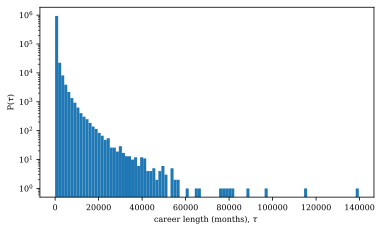

In [157]:

fig = plt.figure(0,figsize=(6, 3.5));
ax = fig.add_subplot(1, 1, 1);

ax.hist(career_lens,100);

# ax.legend(store_lines,leg_,loc=(1.04,0));
ax.set(xlabel=r"career length (months), $\tau$ ", ylabel=r'P($\tau$)');
ax.set_yscale('log',base=10)
# ax.set_xticks(np.linspace(12,48,4));


### Career lengths in years

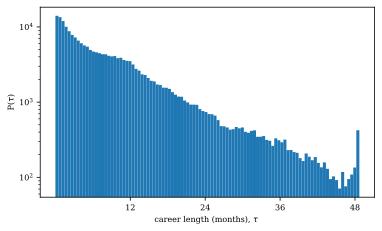

In [125]:
# fig = plt.figure(0,figsize=(6, 3.5));
# ax = fig.add_subplot(1, 1, 1);
# def datetime_to_float(d):
# #     epoch = datetime.utcfromtimestamp(0)
#     total_seconds =  (d).total_seconds()/3600/24/30
#     # total_seconds will be in decimals (millisecond precision)
#     return total_seconds
# X=[datetime_to_float(x) for x in store_career_duration]
# ax.hist(X,100);

# # ax.legend(store_lines,leg_,loc=(1.04,0));
# ax.set(xlabel=r"career length (months), $\tau$ ", ylabel=r'P($\tau$)');
# ax.set_yscale('log',base=10)
# ax.set_xticks(np.linspace(12,48,4));


### Loading parquets and then adding new columns, sorting and saving them back as parquets.

In [2]:
start_time = timeit.default_timer()

t_ic=time.time()

for it_ in range(1,176):
    p=Pool(processes=15)
    names=path_dicts+"parquets/dict_full_careers"+str(it_)+".parquet"

    # names=path_dicts+"parquets/dict_full_careers*" # all files
    files=sorted(glob.glob(names))
#     df_careers = pd.concat(p.map(pd.read_parquet,files),ignore_index=True)
    df_careers = pd.read_parquet(names)

    print('loaded careers=',it_,toc(start_time))
    

    p.close()

    #----------------------------------------------------------
    ### CREATING NEW COLUMNS
    #----------------------------------------------------------

    pd.options.mode.chained_assignment = None  # default='warn'
    # df_careers["is_white"]=""
    df_careers["is_white"]=np.where(df_careers["white_player"]==df_careers["player_id"],1,0)

    t_oc=time.time()
#     with open("/mnt/sdb1/sandeep/0. Careers in chess/0.z_MAIN_progress.txt", "a") as file_object:
#                 file_object.write('IS_WHITE----time (s)-'+str(round(t_oc-t_ic,2))+'\n')


    conditions  = [ (df_careers["result_"]=='1-0') &(df_careers["is_white"]==1),
                   (df_careers["result_"]=='0-1') &(df_careers["is_white"]==0),
                  (df_careers["result_"]=='1/2-1/2')]
    choices     = [ 1,1,0.5 ]    
    df_careers["won_"] = np.select(conditions, choices, default=0)
    t_oc=time.time()
#     with open("/mnt/sdb1/sandeep/0. Careers in chess/0.z_MAIN_progress.txt", "a") as file_object:
#                 file_object.write('won_----time (s)-'+str(round(t_oc-t_ic,2))+'\n')


    df_careers["utcdate"]=df_careers["utcdate"]+' '+df_careers["utctime"]

    t_oc=time.time()
    # with open("/mnt/sdb1/sandeep/0. Careers in chess/0.z_MAIN_progress.txt", "a") as file_object:
    #             file_object.write('IS_WHITE----time (s)-'+str(round(t_oc-t_ic,2))+'\n')


    #----------------------------------------------------------
    ### Merging datetime
    #----------------------------------------------------------


    t_oc=time.time()
    with open("/mnt/sdb1/sandeep/0. Careers in chess/0.z_MAIN_progress.txt", "a") as file_object:
                file_object.write('start datetime_----time (s)-'+str(round(t_oc-t_ic,2))+'\n')

    format_='%Y.%m.%d %H:%M:%S'
    df_careers["utcdate"]=pd.to_datetime(pd.Series(df_careers["utcdate"]), format=format_)


    t_oc=time.time()
    with open("/mnt/sdb1/sandeep/0. Careers in chess/0.z_MAIN_progress.txt", "a") as file_object:
                file_object.write('finished datetime----time (s)-'+str(round(t_oc-t_ic,2))+'\n')

    #----------------------------------------------------------
    ### Finding career start and ends within the dataframe
    #----------------------------------------------------------

    ids=np.array(df_careers['player_id'])
    ind=np.where(~(ids[1:ids.shape[0]]==ids[0:ids.shape[0]-1]))

    ind=ind[0]
    career_lens=ind[1:len(ind)]-ind[0:len(ind)-1]
    tot_careers_=sum(np.array(career_lens)>500)
    ind=[0]+list(ind)

    t_oc=time.time()

    # with open("/mnt/sdb1/sandeep/0. Careers in chess/0.z_MAIN_progress.txt", "a") as file_object:
    #             file_object.write('np where ind----time (s)-'+str(round(t_oc-t_ic,2))+'\n')
    #----------------------------------------------------------
    ### Sorting
    #----------------------------------------------------------
    df_careers=df_careers.sort_values(['player_id', 'utcdate'])
    t_oc=time.time()
#     with open("/mnt/sdb1/sandeep/0. Careers in chess/0.z_MAIN_progress.txt", "a") as file_object:
#                 file_object.write('SORTED----time (s)-'+str(round(t_oc-t_ic,2))+'\n')

    #----------------------------------------------------------
    ### writing to parquet
    #----------------------------------------------------------

    if it_<10:
        modified_it_='0'+'0'+str(it_)
    elif (it_<100):
        modified_it_='0'+str(it_)
    else:
        modified_it_=it_
    names_par=path_dicts+"parquets/a_sorted_full_careers"+str(modified_it_)+".parquet"
    df_careers.to_parquet(names_par,index=None)


    t_oc = time.time();
    print('done=','-----',modified_it_)
    with open("/mnt/sdb1/sandeep/0. Careers in chess/0.z_MAIN_progress.txt", "a") as file_object:
        file_object.write('--i.e.-'+str(modified_it_)+'----time (s)-'+str(round(t_oc-t_ic,2))+'\n')
    
    
    


        


4.391613316722214
loaded careers= 1 None
done= ----- 001
16.925921451300383
loaded careers= 2 None
done= ----- 002
21.210638213902712
loaded careers= 3 None
done= ----- 003
24.743399541825056
loaded careers= 4 None
done= ----- 004
27.691872851923108
loaded careers= 5 None
done= ----- 005
30.88373228441924
loaded careers= 6 None
done= ----- 006
33.91302443481982
loaded careers= 7 None
done= ----- 007
36.63501036912203
loaded careers= 8 None
done= ----- 008
39.40679322369397
loaded careers= 9 None
done= ----- 009
42.22161639481783
loaded careers= 10 None
done= ----- 010
46.34401582367718
loaded careers= 11 None
done= ----- 011
50.43037925846875
loaded careers= 12 None
done= ----- 012
53.40354971587658
loaded careers= 13 None
done= ----- 013
56.182628793641925
loaded careers= 14 None
done= ----- 014
59.186541178263724
loaded careers= 15 None
done= ----- 015
62.493687929585576
loaded careers= 16 None
done= ----- 016
65.20065255463123
loaded careers= 17 None
done= ----- 017
67.7721510948613

In [ ]:
# pd.read_csv.engine='python'
# pd.read_csv.sep='\t'
# #----------------------------------------------------------
# ### LOADING CSVS
# #----------------------------------------------------------

# start_time = timeit.default_timer()
# t_ic=time.time()
# t_oc=time.time()
# with open("/mnt/sdb1/sandeep/0. Careers in chess/0.z_MAIN_progress.txt", "a") as file_object:
#             file_object.write('LOADING----time (s)-'+str(round(t_oc-t_ic,2))+'\n')
        
# p=Pool(processes=10)
# names=path_dicts+"parquets/0.new_dicts_df_career9*" # all files
# files=sorted(glob.glob(names))
# df_careers = pd.concat(p.map(pd.read_csv,files),ignore_index=True)
# print('loaded careers=',toc(start_time))

# t_oc=time.time()
# with open("/mnt/sdb1/sandeep/0. Careers in chess/0.z_MAIN_progress.txt", "a") as file_object:
#             file_object.write('LOADED----time (s)-'+str(round(t_oc-t_ic,2))+'\n')

# p.close()


        
